In [2]:
#importing some stuff, not sure what we will need yet

import tempfile
import os
import time

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import random

from tensorflow import keras
import tensorflow_model_optimization as tfmot
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical


In [3]:
#Loading Training CSV data
train=pd.read_csv("sign_mnist_train.csv")
print(train.shape)
train.head()

(27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
#Loading Testing CSV data
test=pd.read_csv("sign_mnist_test.csv")
print(train.shape)
test.head()

(27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [5]:
#Next we must seperate the labels from the data
label_train=train["label"]
label_test=test["label"]

img_train=train.drop(['label'],axis=1)
img_test=test.drop(['label'],axis=1)

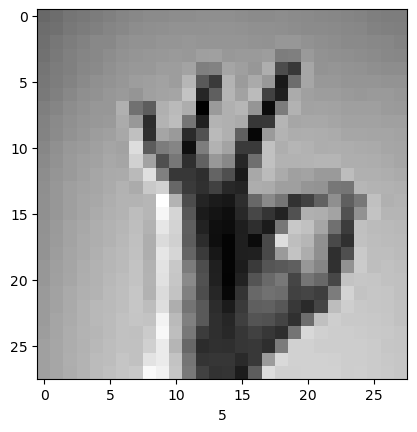

In [6]:
#visualizing what a random image looks like in the dataset to ensure accuracy
sampImg = random.randint(0,len(img_train.index))
fig, ax = plt.subplots()
i=img_train.iloc[sampImg].to_numpy()
i=i.reshape((28,28))
ax.imshow(i, cmap = 'gray')
ax.set_xlabel(label_train.iloc[sampImg])
plt.show()

#A=0
#B=1
#C=2
#etc

In [7]:
#reshaping the image data into a MNIST type format
train_images = img_train.values.reshape(-1,28,28,1)
test_images = img_test.values.reshape(-1,28,28,1)

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

In [8]:
# fixing label data
labels = to_categorical(label_train, num_classes = 25)
labels_test = to_categorical(label_test, num_classes = 25)


In [9]:
#splitting training data to such that we can use the validation dataset for post model metrics lice confusion matrix
X_train, X_val, Y_train, Y_val = train_test_split(train_images, labels, test_size=0.10, random_state=69)

print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (24709, 28, 28, 1)
x_test shape (2746, 28, 28, 1)
y_train shape (24709, 25)
y_test shape (2746, 25)


In [10]:
#creating more data using image data generator (this will be used late, just setting it up)
datagen = ImageDataGenerator(
    rotation_range = 20,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_data = datagen.flow(X_train, Y_train, batch_size = 128)
test_data = datagen.flow(X_val, Y_val, batch_size = 128)

In [11]:
# Define the model architecture.
model = tf.keras.models.Sequential([
    layers.Conv2D(100, (5, 5), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)),
    layers.Conv2D(50, (3, 3), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(10, (3, 3), activation = 'relu', padding = 'same', input_shape = (14, 14, 1)),
    layers.AveragePooling2D(pool_size=(2,2)),

    
    layers.Flatten(),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(25, activation = 'softmax')
])

# summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 100)       2600      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 50)        45050     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 50)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 10)        4510      
                                                                 
 average_pooling2d (Average  (None, 7, 7, 10)          0         
 Pooling2D)                                                      
                                                                 
 flatten (Flatten)           (None, 490)               0

In [16]:
# compilinga and training the model
model.compile(optimizer='rmsprop', # I chose this because adam would not work
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])



In [19]:
# training model
trained_model = model.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
194/194 [==============================] - 41s 211ms/step - loss: 2.6791 - accuracy: 0.1986 - val_loss: 2.2518 - val_accuracy: 0.3077
Epoch 2/10
194/194 [==============================] - 41s 210ms/step - loss: 1.4994 - accuracy: 0.5158 - val_loss: 1.0393 - val_accuracy: 0.6551
Epoch 3/10
194/194 [==============================] - 41s 212ms/step - loss: 0.8357 - accuracy: 0.7199 - val_loss: 0.5708 - val_accuracy: 0.8084
Epoch 4/10
194/194 [==============================] - 42s 219ms/step - loss: 0.5126 - accuracy: 0.8271 - val_loss: 0.3514 - val_accuracy: 0.8857
Epoch 5/10
194/194 [==============================] - 52s 269ms/step - loss: 0.3174 - accuracy: 0.8922 - val_loss: 0.2339 - val_accuracy: 0.9235
Epoch 6/10
194/194 [==============================] - 46s 238ms/step - loss: 0.2303 - accuracy: 0.9236 - val_loss: 0.2308 - val_accuracy: 0.9217
Epoch 7/10
194/194 [==============================] - 47s 242ms/step - loss: 0.1645 - accuracy: 0.9446 - val_loss: 0.1494 - val_ac

In [48]:
# defining some functions to be used later

#model size function
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

#clustering function
def cluster_model(model, num_clust, train_images, train_labels, epochs): 
    # ---------- Defining clustering params ----------
    cluster_weights = tfmot.clustering.keras.cluster_weights

    clustering_params = {
    'number_of_clusters': num_clust,
    'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.KMEANS_PLUS_PLUS,
    'preserve_sparsity': True
    }

    # -------  Clustering --------------
    clustered_model = cluster_weights(model, **clustering_params)

    clustered_model.compile(optimizer='rmsprop', # I chose this because adam would not work
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

    clustered_model.fit(train_images, train_labels, epochs = epochs, validation_split =0.1)

    stripped_clustered_model = tfmot.clustering.keras.strip_clustering(clustered_model)

    # ------- Printing Summary ----------
    clustered_model.summary()

    return clustered_model, stripped_clustered_model

def quantize_model(model, quant):

    #-------------Quantizing------------------
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    if quant == 16: #using float 16 if requested
        converter.target_spec.supported_types = [tf.float16]
        quantized_tflite_model = converter.convert()


    else: #using 8bit
        quantized_tflite_model = converter.convert()
        
    # with open(f'quantized_model.tflite', 'wb') as f:
    #     f.write(quantized_tflite_model)
    # interpreter_quant = tf.lite.Interpreter(model_path=str(f'quantized_model.tflite'))
    # interpreter_quant.allocate_tensors()     



    return quantized_tflite_model

def iterative_prune_model(model, initial_sparsity, final_sparsity, begin_step, end_step, train_images, train_labels, epochs):
  # --------- Pruning Variable Setup ---------
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Define model for pruning.
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=initial_sparsity,
        final_sparsity=final_sparsity, begin_step=begin_step, end_step=end_step, frequency=100)
  }

  # ------------- Pruning Model -------------
  pruned_model = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  pruned_model.compile(optimizer='rmsprop', # I chose this because adam would not work
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])


  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
  ]

  pruned_model.fit(train_images, train_labels, epochs=epochs, validation_split=0.1,
                    callbacks=callbacks)

  # -------- Strip Pruning -------------
  stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

  # ------- Printing Summaries ----------
  pruned_model.summary()
  stripped_pruned_model.summary()

  return pruned_model, stripped_pruned_model



In [ ]:
#saving model
model.save('untrained_signLang_model.h5')

In [20]:
#getting baseline numbers to understand model.
model = tf.keras.models.load_model('trained_signLang_model.h5')

# Evaluate prediction accuracy
test_loss, test_acc = model.evaluate(test_images, labels_test, verbose=2)

# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

#Printing the model size and inference time and accuracy
print("Model Size: %.2f bytes" % (get_gzipped_model_size('untrained_signLang_model.h5')))
print('Model Accuracy:', test_acc*100, '%')
print("Inference Time is", executionTime, "s")

225/225 - 4s - loss: 0.0496 - accuracy: 0.9856 - 4s/epoch - 20ms/step
225/225 [==============================] - 5s 20ms/step
Model Size: 2358050.00 bytes
Model Accuracy: 98.56386184692383 %
Inference Time is 0.0006865563169246403 s


In [32]:
# first thing we will do to reduce model size is prune it

# load model
loaded_model = tf.keras.models.load_model('trained_signLang_model.h5')

#variables that are to be manipulated
initial_sparsity = 0.1
final_sparsity = 0.9
begin_step = 0
end_step = 100
epochs = 2

#function call
pruned_model, stripped_pruned_model = iterative_prune_model(loaded_model, initial_sparsity, final_sparsity, 
                                                            begin_step, end_step, train_images, 
                                                            labels, epochs)


Epoch 1/2
773/773 [==============================] - 61s 74ms/step - loss: 0.8315 - accuracy: 0.7419 - val_loss: 0.3689 - val_accuracy: 0.9472
Epoch 2/2
773/773 [==============================] - 60s 78ms/step - loss: 0.1632 - accuracy: 0.9957 - val_loss: 0.0761 - val_accuracy: 1.0000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 28, 28, 100)       5102      
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_conv2d  (None, 28, 28, 50)        90052     
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 50)        1         
 oling2d (PruneLowMagnitude                                      
 )                                

In [51]:
#saving model
stripped_pruned_model.save('stripPruned_signLang_model.h5')

c:\Users\mnorr\Anaconda3\envs\ensf-ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )
print_model_weights_sparsity(stripped_pruned_model)

conv2d/kernel:0: 90.00% sparsity  (2250/2500)
conv2d_1/kernel:0: 90.00% sparsity  (40500/45000)
conv2d_2/kernel:0: 90.00% sparsity  (4050/4500)
dense/kernel:0: 90.00% sparsity  (220500/245000)
dense_1/kernel:0: 90.00% sparsity  (45000/50000)
dense_2/kernel:0: 90.00% sparsity  (2250/2500)


In [53]:
#getting baseline numbers to understand model.
s_model = pruned_model
# Evaluate prediction accuracy
test_loss, test_acc = s_model.evaluate(test_images, labels_test, verbose=2)

# Evaluate Inference Time
startTime = time.time()
prediction = s_model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

#Printing the model size and inference time and accuracy
print("Model Size: %.2f bytes" % (get_gzipped_model_size('stripPruned_signLang_model.h5')))
print('Model Accuracy:', test_acc*100, '%')
print("Inference Time is", executionTime, "s")

225/225 - 4s - loss: 0.4194 - accuracy: 0.8854 - 4s/epoch - 19ms/step
225/225 [==============================] - 5s 20ms/step
Model Size: 271914.00 bytes
Model Accuracy: 88.53875994682312 %
Inference Time is 0.0006623558006137693 s


In [55]:
#clustering the pruned model and perserving its sparcity

model = tf.keras.models.load_model('stripPruned_signLang_model.h5')

#defining some variables
num_clust = 16

#Function call
clustered_model, strip_clust_model = cluster_model(model, num_clust, train_images, labels, epochs)

strip_clust_model.save('stripClust_signLang_model.h5')


Epoch 1/2
773/773 [==============================] - 80s 99ms/step - loss: 0.0972 - accuracy: 0.9953 - val_loss: 0.0569 - val_accuracy: 0.9996
Epoch 2/2
773/773 [==============================] - 74s 95ms/step - loss: 0.0320 - accuracy: 0.9996 - val_loss: 0.0185 - val_accuracy: 1.0000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d (ClusterWei  (None, 28, 28, 100)       5116      
 ghts)                                                           
                                                                 
 cluster_conv2d_1 (ClusterW  (None, 28, 28, 50)        90066     
 eights)                                                         
                                                                 
 cluster_max_pooling2d (Clu  (None, 14, 14, 50)        0         
 sterWeights)                                                    
                                  

TypeError: cannot unpack non-iterable Sequential object

In [ ]:
#getting baseline numbers to understand model.
c_model = cluster_model
# Evaluate prediction accuracy
test_loss, test_acc = c_model.evaluate(test_images, labels_test, verbose=2)

# Evaluate Inference Time
startTime = time.time()
prediction = c_model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

#Printing the model size and inference time and accuracy
print("Model Size: %.2f bytes" % (get_gzipped_model_size('stripClust_signLang_model.h5')))
print('Model Accuracy:', test_acc*100, '%')
print("Inference Time is", executionTime, "s")

In [26]:
# Next we will quantize the pruned model

#loading model
model = tf.keras.models.load_model('stripPruned_signLang_model.h5')

#Defining some new variables
quant = 8

#function call
quantized_tflite_model = quantize_model(model, quant)

INFO:tensorflow:Assets written to: C:\Users\mnorr\AppData\Local\Temp\tmpkktnwbz7\assets


INFO:tensorflow:Assets written to: C:\Users\mnorr\AppData\Local\Temp\tmpkktnwbz7\assets
